# Testing the Discrete Hankel Transform

## Theory of DHT

**Note, the majority of this theory comes directly from** http://trace.tennessee.edu/cgi/viewcontent.cgi?article=4324&context=utk_gradthes.

The Hankel Transform is (https://en.wikipedia.org/wiki/Hankel_transform#Definition)
$$ F_\nu(k) = a^{-1} \int_0^\infty f(r) J_\nu(bkr) r dr$$,
with inverse
$$ f(r) = a \int_0^\infty F_\nu(k) J_\nu(bkr) k dk$$.

Let's say we have $F(k)$ on a regular grid. Here we make the assumption that the width of the grid cells is $\Delta k$, and there are $N$ of them, all with $k\geq0$. We want to evaluate the transform on another regular grid of $r$, which has the same length. 

This can be approximated as a sum (we use the inverse here for example):
$$ f(r_j) \approx a \sum_{i=0}^{N} F_\nu(\Delta k i) \Delta k i J_\nu(b \Delta r j \Delta k i) \Delta k.$$

Let's specify that $\Delta k \Delta r = 1/N$, then this becomes
$$ f(r_j) = a (\Delta k)^2 \sum_{i=0}^{N} F_\nu(k_i) i J_\nu(b ji/N).$$



## Define the DHT and FHT functions

In [27]:
# -*- coding: utf-8 -*-
from __future__ import absolute_import
from __future__ import division
from __future__ import unicode_literals
import numpy as np
import abel
from scipy.special import jn
from scipy.ndimage import zoom
import matplotlib.pyplot as plt

%matplotlib inline

#############################################################################
#
# Fourier-Hankel method:    A = H F
#
# 2017-08-29 
#  see https://github.com/PyAbel/PyAbel/issues/24#issuecomment-325547436
#  Steven Murray - implementation
#  Stephen Gibson, Dan Hickstein - adapted for PyAbel
#
#############################################################################

def construct_dht_matrix(N, nu  = 0, b = 1):
    """
    Construct the Discrete Hankel Transform matrix of size N.
    
    Parameters
    ----------
    N : int
        The size of the matrix to construct
        
    nu : float, optional
        The order of the Hankel transformation
        
    b : float, optional
        Defines the convention of the Hankel transformation, with respect to frequency.
        Common conventions are ``b=1`` and ``b=2*pi``.
        
    Returns
    -------
    F : array of floats
        An (NxN) symmetric array which is the DHT matrix.
        
    Notes
    -----
    The DHT matrix is defined as 
    
    .. math:: F_{ij} = J_\nu(bij/N).
    """
    m = np.arange(0, N).astype('float')
    return jn(nu, np.outer(b*m, m/N))


def dht(X, d = 1, nu = 0, axis=-1, a = 1, b = 1):
    """
    Perform a Discrete Hankel Transform on the array X.
    
    Parameters
    ----------
    X : array
        The array to be transformed.
        
    d : float, optional
        The grid-size of the array. Leaving as default gives the "pixel" transformation.
        
    nu : float, optional
        The order of the transform.
        
    axis : int, optional
        The axis over which to take the transform.
        
    a,b : float, optional
        These define the transform convention in terms of amplitude and frequency.
        
    Returns
    -------
    H : array
        An array of the same shape as X, which is the Hankel Transform of X.
        The transform is taken over `axis`, for all other axes. 
        
    Notes
    -----
    The DHT is defined as (see http://trace.tennessee.edu/cgi/viewcontent.cgi?article=4324&context=utk_gradthes)
    
    .. math:: H_{ij} = \frac{a}{(Nd)^2} F_{ij} i X_i
    """
    N = X.shape[axis]
    F = construct_dht_matrix(N,nu,b)*np.arange(0,N)
    return a * d**2 * np.tensordot(F, X, axes=([1],[axis])) 


## Test Pure DHT

The idea here is to take various analytic transforms from https://en.wikipedia.org/wiki/Hankel_transform#Some_Hankel_transform_pairs and show that the DHT can reproduce them.

### Grid Setup

In [140]:
N = 1024
r = np.linspace(0,10,N)
dr = r[1] - r[0]
dk = 1/(len(r)*dr)
k = np.linspace(0,(N-1)*dk, N)
print dr

0.00977517106549


### Gaussian

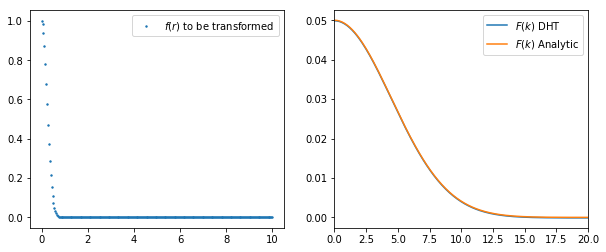

In [61]:
a2 = 20
f = np.exp(-0.5 * a2 * r**2)
Fanl = (1/a2) * np.exp(-0.5*k**2 / a2)

Fnum = dht(f, d = dr, nu=0)

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].scatter(r, f, label="$f(r)$ to be transformed", s=2)
ax[0].legend()

ax[1].plot(k, Fnum, label="$F(k)$ DHT")
ax[1].plot(k, Fanl, label="$F(k)$ Analytic")
ax[1].set_xlim(0,a2)
ax[1].legend()

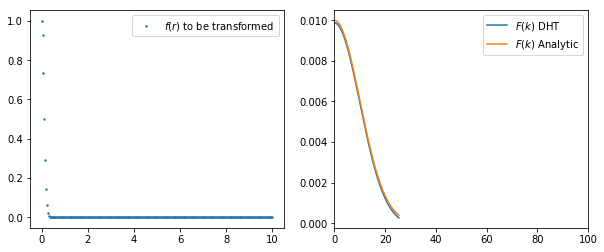

In [63]:
a2 = 100
f = np.exp(-0.5 * a2 * r**2)
Fanl = (1/a2) * np.exp(-0.5*k**2 / a2)

Fnum = dht(f, d = dr, nu=0)

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].scatter(r, f, label="$f(r)$ to be transformed", s=2)
ax[0].legend()

ax[1].plot(k, Fnum, label="$F(k)$ DHT")
ax[1].plot(k, Fanl, label="$F(k)$ Analytic")
ax[1].set_xlim(0,a2)
ax[1].legend()

This seems to work perfectly well unless the number of points in the "bell" of the curve is too few. Then we miss some power, and the DHT drops a bit.  

### Power-Laws

/home/steven/miniconda3/envs/hankel2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/home/steven/miniconda3/envs/hankel2/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


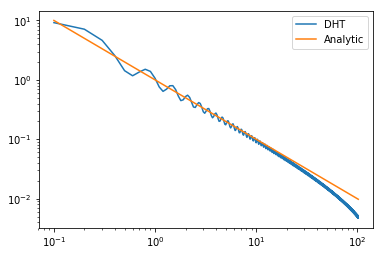

In [72]:
f = 1/r
f[0] = 0
Fanl = 1/k

Fnum = dht(f, d = dr, nu = 0)

plt.plot(k, Fnum, label="DHT")
plt.plot(k, Fanl, label="Analytic")
plt.yscale("log")
plt.xscale('log')
plt.legend()

I think the discrepancy here is a limitation of the method -- the oscillations occur because we're roughly sampling a highly-oscillatory function. The function $1/r$ does not fall fast enough to make the high-$r$ oscillations negligible (as the exponential does), and so these oscillations in the function bite us.

### Damped power law

/home/steven/miniconda3/envs/hankel2/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


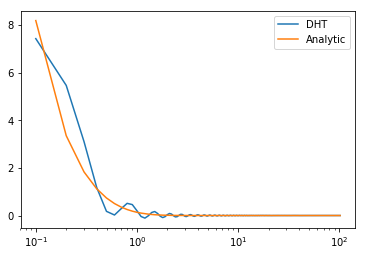

In [83]:
z = 2.
f = 1/ np.sqrt(r**2 + z**2)
Fanl = np.exp(- k*z)/k

Fnum = dht(f, d = dr, nu = 0)

plt.plot(k, Fnum, label="DHT")
plt.plot(k, Fanl, label="Analytic")
#plt.yscale("log")
plt.xscale('log')
plt.legend()

This seems to do alright, except for the oscillations. In log-space, however, you can see that the DHT doesn't go below about 1e-5, while the analytic falls off exponentially.

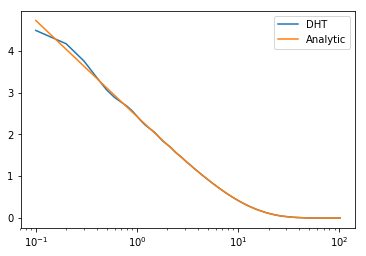

In [88]:
from scipy.special import k0

z = 0.1
f = 1/ (r**2 + z**2)
Fanl = k0(k*z)

Fnum = dht(f, d = dr, nu = 0)

plt.plot(k, Fnum, label="DHT")
plt.plot(k, Fanl, label="Analytic")
#plt.yscale("log")
plt.xscale('log')
plt.legend()

As predicted, the oscillations are more damped here, because this falls off as $r^{-2}$.

### Higher-order transform (power-law)

/home/steven/miniconda3/envs/hankel2/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in power
/home/steven/miniconda3/envs/hankel2/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in true_divide
/home/steven/miniconda3/envs/hankel2/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in reciprocal


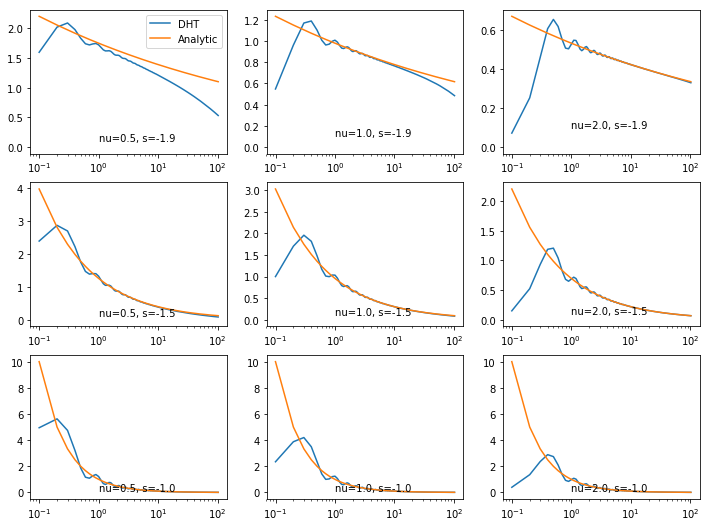

In [93]:
from scipy.special import gamma

fig, ax = plt.subplots(3,3, figsize = (12,9), subplot_kw={"xscale":'log'})

for i,s in enumerate([-1.9,-1.5, -1.0]):
    for j, nu in enumerate([0.5, 1.0, 2.0]):

        f = r**s
        f[0] = 0
        Fanl = 2**(s+1) * gamma(0.5*(2+nu+s))/(k**(s+2)*gamma(0.5*(nu-s)))

        Fnum = dht(f, d = dr, nu = nu)

        ax[i,j].plot(k, Fnum, label="DHT")
        ax[i,j].plot(k, Fanl, label="Analytic")
        ax[i,j].text(1.0, 0.1, "nu=%s, s=%s"%(nu, s))
        if i==0 and j==0:
            ax[i,j].legend()

This all kind of follows intuition, so I'm happy that the functions are correct.

## Define FHT Functions

http://dsp-book.narod.ru/TAH/ch08.pdf

In [169]:
def dft(X, axis=-1):
    # discrete Fourier transform
    n = X.shape[axis]
        
    # Build a slicer to remove last element from flipped array
    slc = [slice(None)] * len(X.shape)
    slc[axis] = slice(None,-1)
    
    X = np.append(np.flip(X,axis)[slc], X, axis=axis)  # make symmetric

    return np.abs(np.fft.rfft(X, axis=axis)[:n])/n


def dfht(X, d=1, inverse=True, axis=-1):
    """
    Perform a discrete Fourier-Hankel transform on X [WK]
    
    Parameters
    ----------
    X : nd array
        The array over which to perform the transform.
        
    d : float, optional
        Sampling size (=1 for pixel images), used for Jacobian scaling.
        
    inverse : bool, optional
        Whether to perform the inverse dhft (Abel) transform.
        
    axis : int, optional
        The axis over which to perform the transform.
        
    Returns
    -------
    A : nd-array
        An array of the same shape as `X` which is the Abel transform (or discrete 
        Fourier-Hankel transform) of `X` over `axis`.
        
    Notes
    -----
    The discrete FH transform is defined as :math:`A = F^{-1}Hx`, where :math:`F` is the 
    DFT matrix, and :math:`H` is the Hankel transform.
    
    References
    ----------
    [WK] https://en.wikipedia.org/wiki/Hankel_transform#Relation_to_the_Fourier_and_Abel_transforms
    """
    n = X.shape[axis]
    
    if inverse:
        fx = dft(X, axis=axis)  # Fourier transform
        hf = dht(fx, d=1/(n*d), b=np.pi, axis=axis) * n/2  # Hankel transform
    else:
        hx = dht(X, d=1/(n*d), b=np.pi, axis=axis) * 2
        hf = dft(hx)
    
    return hf


def fourier_hankel_transform(IM, dr=1, inverse=True, basis_dir=None):
    """
    Parameters
    ----------
    IM : 1D or 2D numpy array
        Right-side half-image (or quadrant).
    dr : float
        Sampling size (=1 for pixel images), used for Jacobian scaling.
    direction : str
        'inverse' or 'forward' Abel transform
    Returns
    -------
    trans_IM : 1D or 2D numpy array
        Inverse or forward Abel transform half-image, the same shape as IM.
    """
    IM = np.atleast_2d(IM)
    transform_IM = hankel_fourier_transform(IM, inverse=inverse)
    
    if transform_IM.shape[0] == 1:
        transform_IM = transform_IM[0]   # flatten to a vector

    return transform_IM

## Test Fourier-Hankel Transform

In [163]:
N = 1024
r = np.linspace(0,4.0,N)
dr = r[1] - r[0]
dk = 1/(len(r)*dr)
k = np.linspace(0,(N-1)*dk, N)
print dr

0.0039100684262


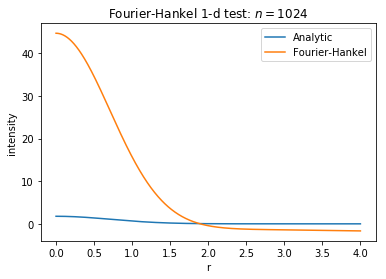

In [170]:
# Gaussian function
a2 = 1.0
f = np.exp(- a2 *r**2)


fhIM = dfht(f, d= dr)
#tpIM = abel.dasch.three_point_transform(f)

fig, ax = plt.subplots()
ax.plot(r, np.sqrt(np.pi)*f,
        label=r'Analytic')
ax.plot(r, fhIM, label=r'Fourier-Hankel')
#ax.plot(r, tpIM , label=r'3pt')
ax.set_title('Fourier-Hankel 1-d test: $n={}$'.format(N))
#ax.axis(xmax=n*0.6)
ax.set_xlabel('r')
ax.set_ylabel('intensity')
ax.legend();

#plt.savefig("Fourier-Hankel-1D-Gauss.png", dpi=75)
#plt.show()

In [166]:
fhIM

array([ 268.12572629,  268.12143495,  268.10870578, ...,   -9.95209453,
         -9.96017124,   -9.96827155])

In [152]:
abel.dasch.three_point_transform?

TypeError: Invalid dimensions for image data

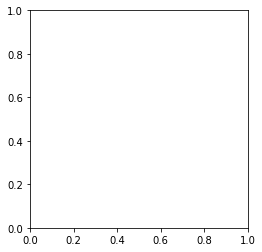

In [115]:
plt.imshow(IM.func)

In [51]:
%timeit fourier_hankel_transform(X)

10 loops, best of 3: 26.6 ms per loop


In [47]:
X = np.repeat(IM.func, 257).reshape(257,257)

\begin{align}
2\pi \int_0^1 rf(r) J_0(2\pi kr) dr &= \frac{J_1(2k\pi)}{k} + \frac{3}{4}\frac{\pi k J_3(\pi k) -2J_2(\pi k)}{\pi k^2} \\
& +4\frac{J_2(2k\pi)-k\pi J_3(2k\pi)}{\pi k^2} \\
& -8\pi \left[\frac{r^3}{3}{}_1F_2(3/2;1,5/2;-k^2\pi^2r^2)\right]_{1/2}^1.
\end{align}

\begin{align}
2\pi \int_0^1 rf(r) J_0(2\pi kr) dr &= \frac{J_1(2k\pi) + 0.75J_3(\pi k) - 4J_3(2\pi k)}{k} + \frac{4J_2(2\pi k)-1.5 J_2(\pi k)}{\pi k^2} \\
& -8\pi \left[\frac{r^3}{3}{}_1F_2(3/2;1,5/2;-k^2\pi^2r^2)\right]_{1/2}^1.
\end{align}